<a href="https://colab.research.google.com/github/davkeem/SHAZAM-CAPSTONE/blob/main/shazam_query_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import drive
import os


drive.mount('/content/drive')

hist_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/hist_data'


chroma_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/dataset_processed/processed_chroma/ml_processed_data'
harmonic_data_folder ='/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/dataset_processed/processed_harmonic/ml_processed_data'
mfcc_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/mfcc'
onset_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/dataset_processed/processed_onset/ml_processed_data'
percussive_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/dataset_processed/processed_percussive/ml_processed_data'
spectral_centroid_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/dataset_processed/processed_spectral_centroid/ml_processed_data'
spectral_contrast_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/dataset_processed/processed_spectral_contrast/ml_processed_data'
tempo_beats_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/dataset_processed/processed_tempo_beats/ml_processed_data'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This loads the csv files, skips the first row and column of labels, and pads the histogram array to match up with the mfcc array.

Expected data shapes:
X shape: (20, 550, 14)
y shape: (20, 550, 1)

In [13]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences

def load_data(directory):
    data = []
    for file_name in sorted(os.listdir(directory)):
        if file_name.endswith('.csv'):
            file_path = os.path.join(directory, file_name)
            df = pd.read_csv(file_path, header=None, skiprows=1)
            # Clean the data to remove brackets and convert to float
            df = df.replace(r'[\[\]]', '', regex=True).astype(float) #Tempo beats data has brackets
            data.append(df.iloc[:, 1:].values)  # Exclude the time bin column
    max_length = max(array.shape[0] for array in data)  # Find the max length
    padded_data = pad_sequences(data, maxlen=max_length, padding='post', dtype='float32')  # Pad sequences
    return np.array(padded_data)

# Load data from all specified folders
mfcc_data = load_data(mfcc_data_folder)
hist_data = load_data(hist_data_folder)
chroma_data = load_data(chroma_data_folder)
harmonic_data = load_data(harmonic_data_folder)
onset_data = load_data(onset_data_folder)
percussive_data = load_data(percussive_data_folder)
spectral_centroid_data = load_data(spectral_centroid_data_folder)
spectral_contrast_data = load_data(spectral_contrast_data_folder)
tempo_beats_data = load_data(tempo_beats_data_folder)

print(f"MFCC Data Shape: {mfcc_data.shape}")
print(f"Histogram Data Shape: {hist_data.shape}")
print(f"Chroma Data Shape: {chroma_data.shape}")
print(f"Harmonic Data Shape: {harmonic_data.shape}")
print(f"Onset Data Shape: {onset_data.shape}")
print(f"Percussive Data Shape: {percussive_data.shape}")
print(f"Spectral Centroid Data Shape: {spectral_centroid_data.shape}")
print(f"Spectral Contrast Data Shape: {spectral_contrast_data.shape}")
print(f"Tempo Beats Data Shape: {tempo_beats_data.shape}")

# Concatenate all the feature datasets into X
X = np.concatenate(
    [
        mfcc_data,
        chroma_data,
        harmonic_data,
        onset_data,
        percussive_data,
        spectral_centroid_data,
        spectral_contrast_data,
        tempo_beats_data,
    ],
    axis=2,  # Concatenate along the feature axis
)

# Set y to be the histogram data
y = hist_data

# Print shapes for verification
print(f"X shape: {X.shape}")  # Combined features: (num_samples, time_steps, total_features)
print(f"y shape: {y.shape}")  # Labels: (num_samples, time_steps)





MFCC Data Shape: (20, 550, 14)
Histogram Data Shape: (20, 550, 1)
Chroma Data Shape: (20, 550, 13)
Harmonic Data Shape: (20, 550, 14)
Onset Data Shape: (20, 550, 2)
Percussive Data Shape: (20, 550, 14)
Spectral Centroid Data Shape: (20, 550, 2)
Spectral Contrast Data Shape: (20, 550, 8)
Tempo Beats Data Shape: (20, 550, 3)
X shape: (20, 550, 70)
y shape: (20, 550, 1)


Work In Progress

My first attempt at LOO (Leave One Out) Cross Validation modeling.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1: Leaving out song at index 0
Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 6836388.5000
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 5078959.0000
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - loss: 3820286.2500
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - loss: 2919016.0000
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 2264221.2500
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 1848505.8750
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - loss: 1566333.5000
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 1458795.5000
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 1414474.2500
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 1411739.0000
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 1412570.3750
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 1399016.0000
Epoch 13/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 1354897.6250
Epoch 14/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

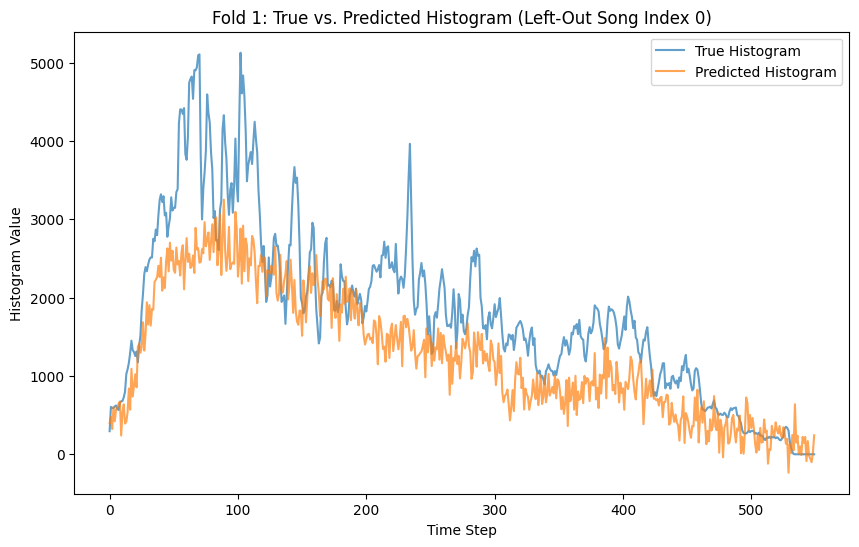

Fold 2: Leaving out song at index 1
Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 719466.5000
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 721011.5000
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 691707.2500
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 690768.2500
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - loss: 674911.1875
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 663688.5000
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 661610.1875
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 657953.5000
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 643097.3750
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 651096.2500
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 620734.3750
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 605643.4375
Epoch 13/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 602171.5625
Epoch 14/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step

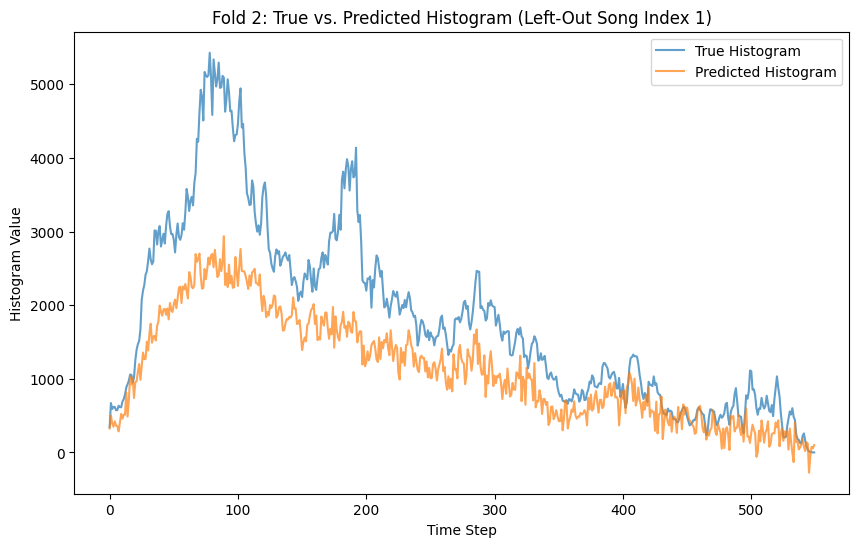

Fold 3: Leaving out song at index 2
Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - loss: 443283.2188
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step - loss: 438469.2500
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - loss: 434250.2188
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 426336.2500
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 414563.4062
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 415802.5938
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 411707.1562
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 413148.0000
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 395375.6250
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - loss: 407390.7188
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 398729.3125
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 400196.7500
Test MSE for this fold: 1043367.5625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Test RMSE for this fold: 1021.45361328125


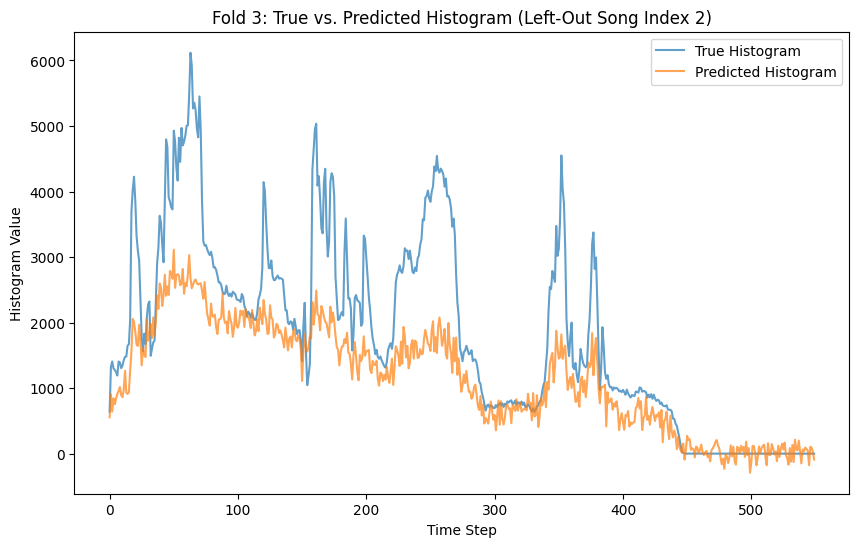

Fold 4: Leaving out song at index 3
Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 399027.5938
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 378297.5938
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 394538.7500
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 369539.5000
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 401960.6875
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 383306.0312
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 367229.4375
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - loss: 364811.2188
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 366361.5000
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - loss: 366225.9375
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 358403.0625
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step - loss: 359433.6875
Epoch 13/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - loss: 343718.4688
Epoch 14/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step

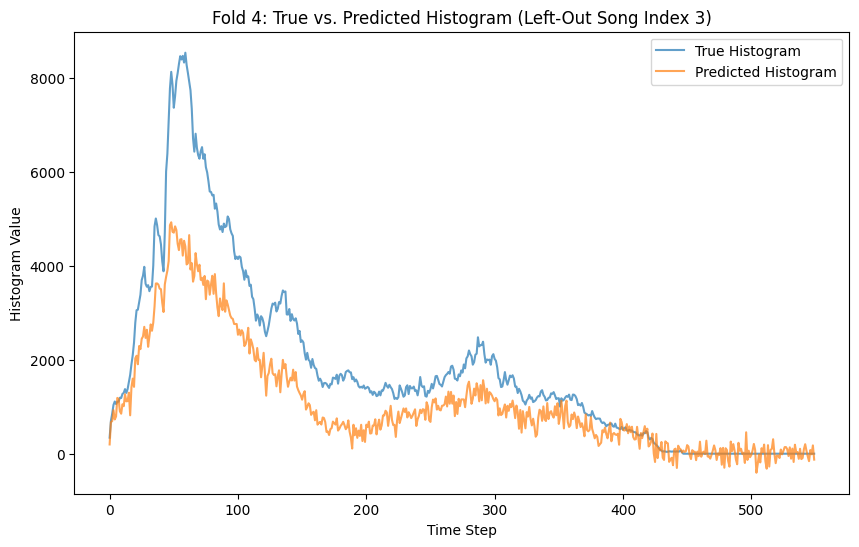

Fold 5: Leaving out song at index 4
Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - loss: 315682.4062
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 303453.0938
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 302650.1250
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 290492.3125
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 298106.3125
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 291479.9375
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 281373.2500
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 286469.7812
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 285130.0625
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 279754.9688
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - loss: 278274.6562
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 279752.7188
Epoch 13/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 274071.6562
Epoch 14/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step

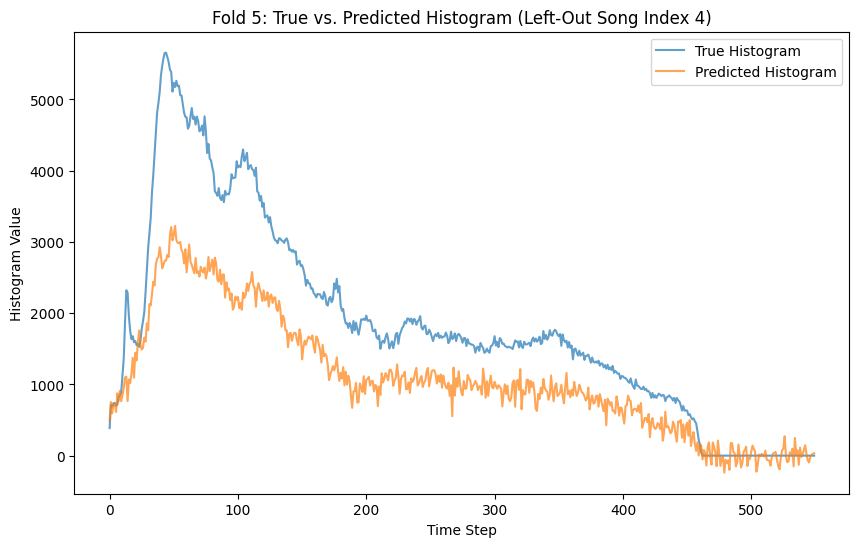

Fold 6: Leaving out song at index 5
Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 240424.1250
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 244013.1875
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 238560.8438
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 232327.9531
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - loss: 242618.9531
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step - loss: 239064.6094
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step - loss: 233715.9688
Test MSE for this fold: 974912.875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Test RMSE for this fold: 987.3767700195312


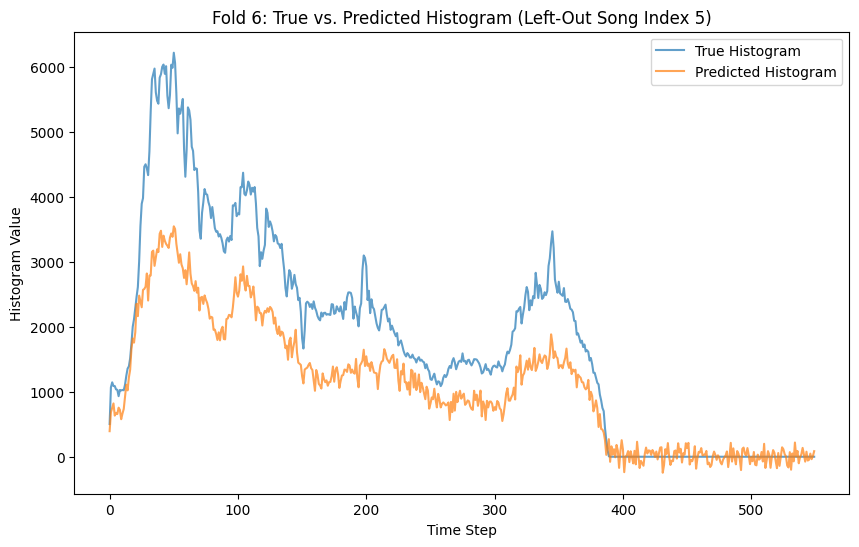

Fold 7: Leaving out song at index 6
Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - loss: 236397.5312
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - loss: 226136.3438
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - loss: 232890.6094
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step - loss: 226036.6875
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - loss: 234591.3906
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step - loss: 232530.0312
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 218941.9531
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 225020.2031
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 222534.6875
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 216341.9688
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 215057.8750
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 215871.9844
Epoch 13/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 210846.4375
Epoch 14/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step

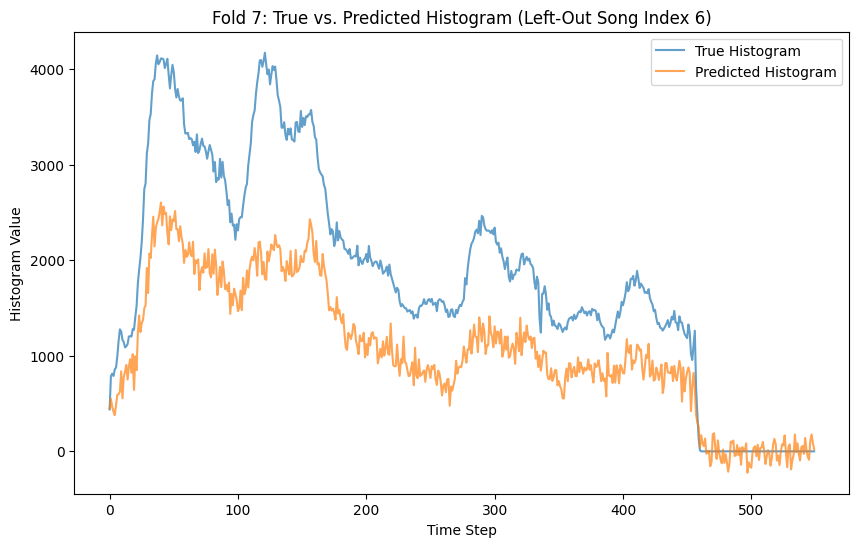

Fold 8: Leaving out song at index 7
Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 195548.0312
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - loss: 197545.0625
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 188616.5938
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - loss: 199461.8125
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 189672.0469
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 191852.8281
Test MSE for this fold: 1142698.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Test RMSE for this fold: 1068.970458984375


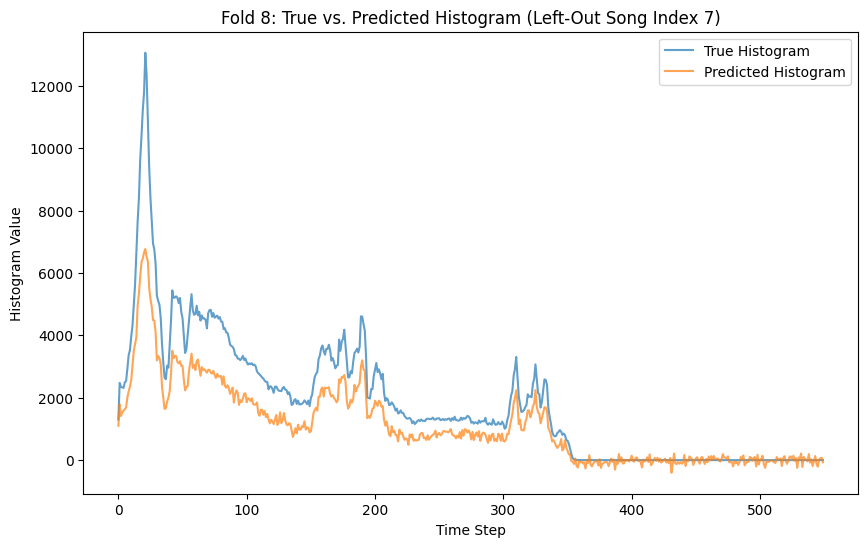

Fold 9: Leaving out song at index 8
Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 197081.4375
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 193556.0781
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 191971.6875
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 187355.9688
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 187135.4062
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 184296.9531
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 182728.3281
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 187492.5000
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 180906.6250
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step - loss: 181986.7656
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - loss: 173751.3281
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step - loss: 179553.0625
Epoch 13/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - loss: 174770.9531
Epoch 14/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step

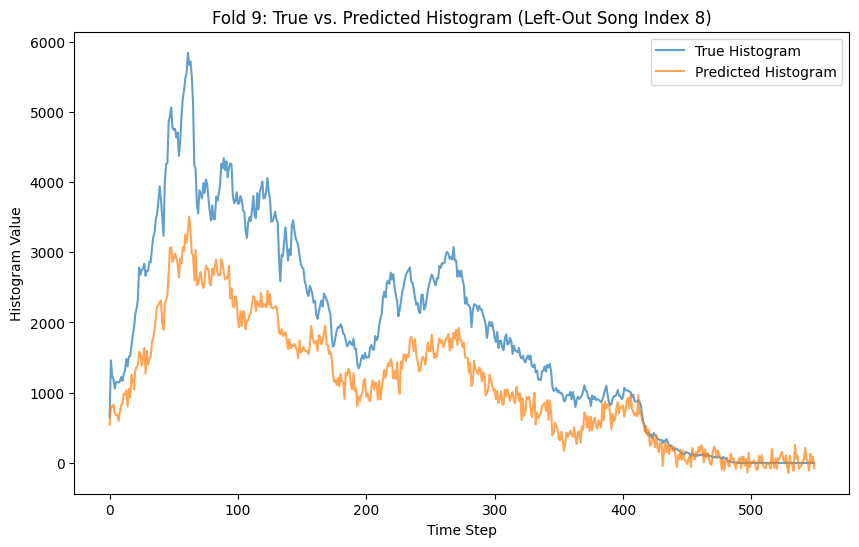

Fold 10: Leaving out song at index 9
Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - loss: 163753.7188
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step - loss: 167029.7344
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step - loss: 170161.0469
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step - loss: 158923.4844
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step - loss: 164947.2812
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 165380.5625
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 169183.1094
Test MSE for this fold: 1265983.125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Test RMSE for this fold: 1125.1591796875


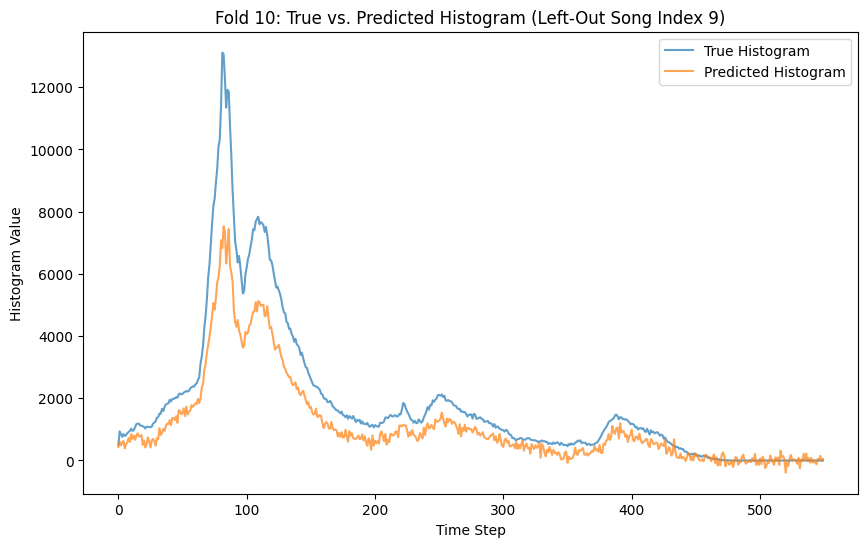

Fold 11: Leaving out song at index 10
Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 169428.3125
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 175923.5000
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 165501.6250
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 159215.4688
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - loss: 165035.9531
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 164304.1562
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - loss: 170648.4531
Test MSE for this fold: 805147.625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test RMSE for this fold: 897.3002319335938


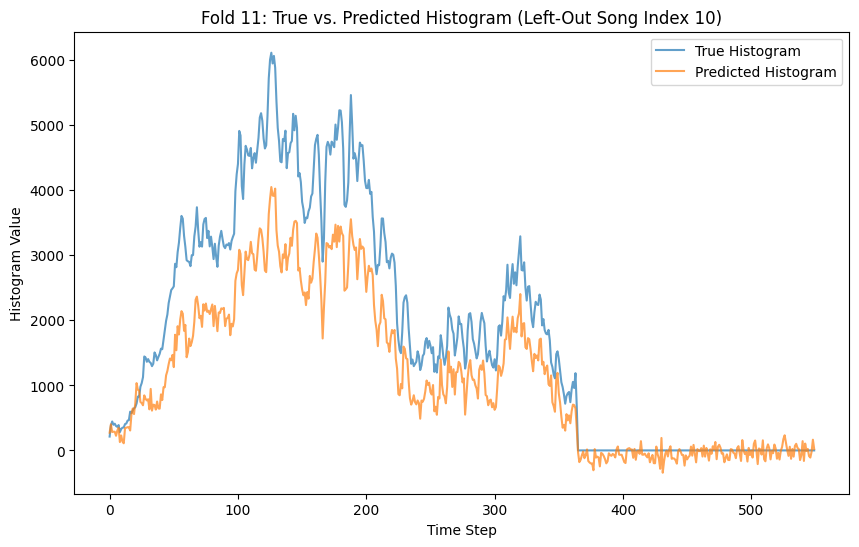

Fold 12: Leaving out song at index 11
Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 165906.9531
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 163791.5938
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: 162260.2031
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 157226.0469
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 159604.9688
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 160506.1250
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 155041.1094
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 156030.8750
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 162264.2188
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 153654.5156
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 151741.5625
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: 150770.9375
Epoch 13/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 150969.0469
Epoch 14/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/st

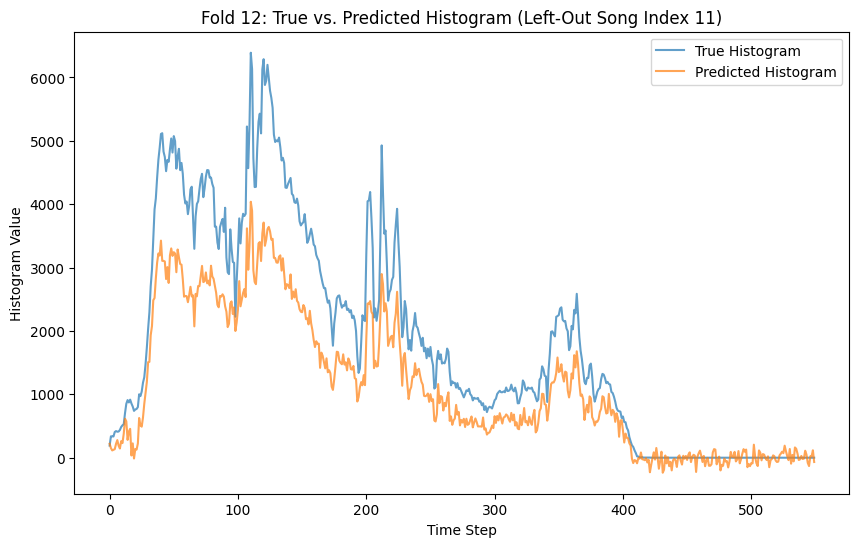

Fold 13: Leaving out song at index 12
Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 154770.3438
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 155063.5938
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 151456.0000
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 147460.8750
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - loss: 151746.3594
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - loss: 145462.4375
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step - loss: 151114.2969
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step - loss: 145879.6875
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step - loss: 147881.7656
Test MSE for this fold: 748429.9375
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Test RMSE for this fold: 865.118408203125


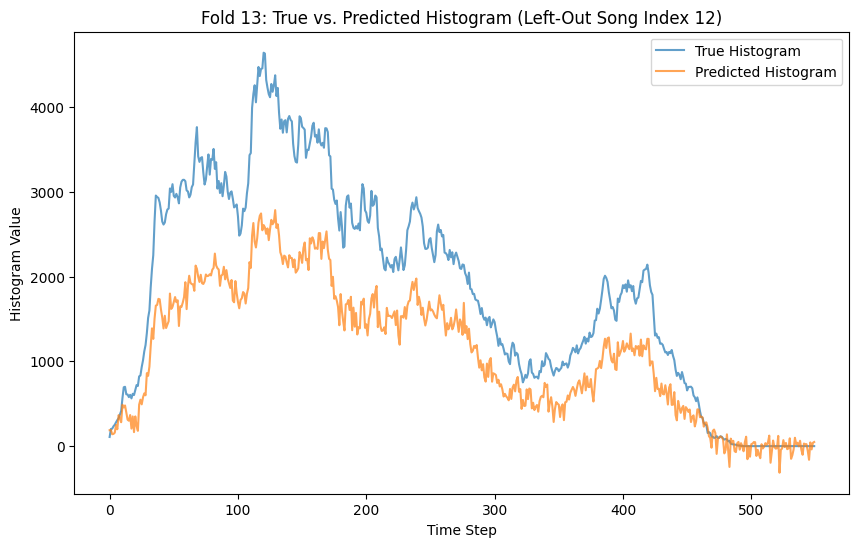

Fold 14: Leaving out song at index 13
Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - loss: 142603.8594
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step - loss: 149324.3125
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - loss: 137110.2969
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - loss: 142671.2031
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 143064.3750
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 140342.1406
Test MSE for this fold: 803166.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Test RMSE for this fold: 896.1957397460938


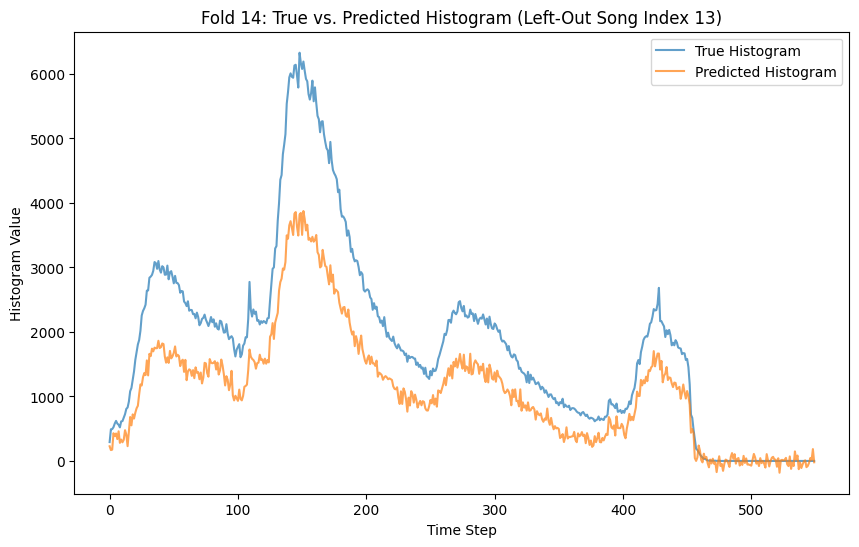

Fold 15: Leaving out song at index 14
Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 140088.2656
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 135792.7500
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - loss: 136918.3281
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 130812.4609
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - loss: 133772.3281
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 136327.9062
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 130949.3984
Test MSE for this fold: 964535.0625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Test RMSE for this fold: 982.107421875


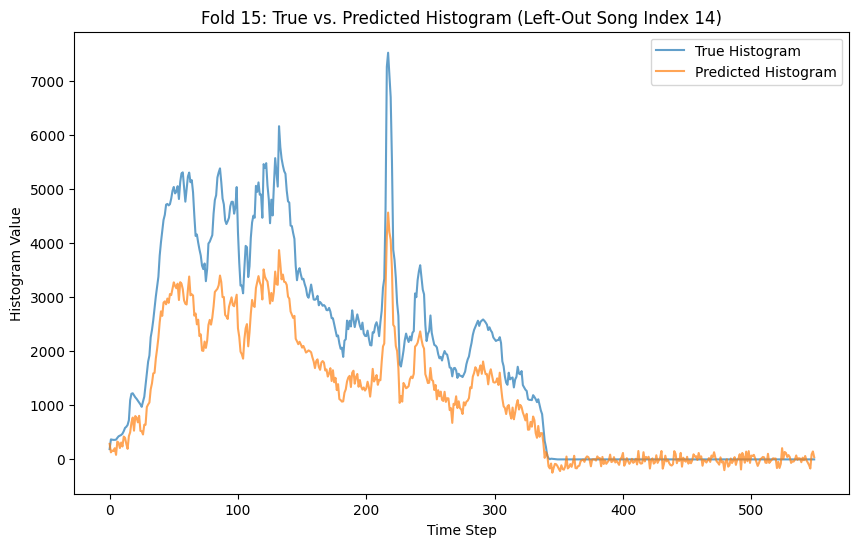

Fold 16: Leaving out song at index 15
Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 133936.6250
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 132110.8594
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 136963.9844
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 130789.6172
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - loss: 135525.7500
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - loss: 134819.5312
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - loss: 133132.5938
Test MSE for this fold: 877003.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Test RMSE for this fold: 936.484375


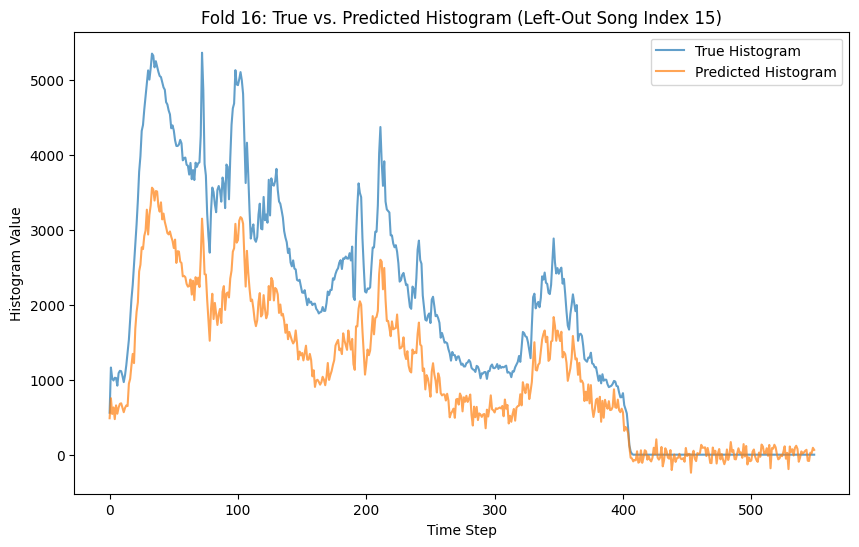

Fold 17: Leaving out song at index 16
Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - loss: 130168.9844
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 130753.6328
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - loss: 131987.0156
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 129517.0234
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - loss: 131291.0781
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - loss: 124942.1719
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 128369.6016
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 125363.3438
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - loss: 130988.6562
Test MSE for this fold: 785107.625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Test RMSE for this fold: 886.06298828125


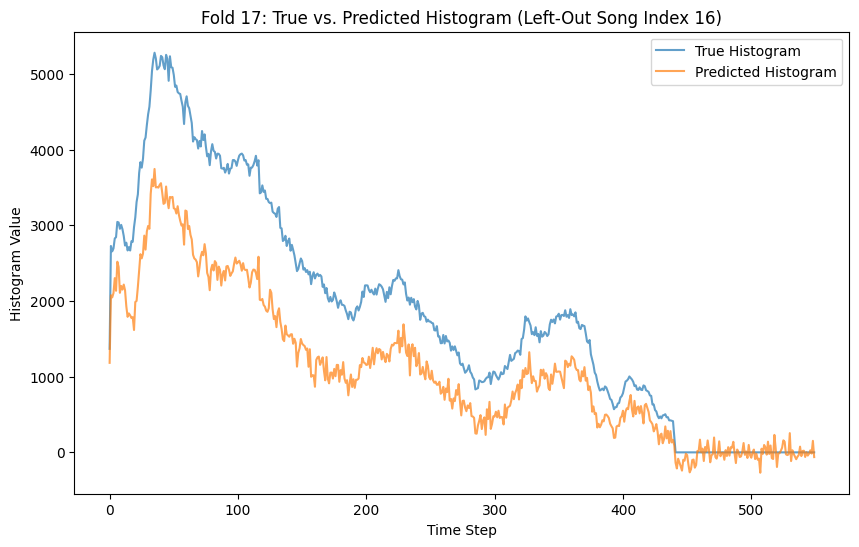

Fold 18: Leaving out song at index 17
Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - loss: 127763.5234
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - loss: 124400.3984
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - loss: 130636.9219
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - loss: 127648.7109
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - loss: 120039.1875
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - loss: 118805.0234
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - loss: 122345.0781
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - loss: 121198.6484
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step - loss: 122339.3672
Test MSE for this fold: 800809.8125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Test RMSE for this fold: 894.8796997070312


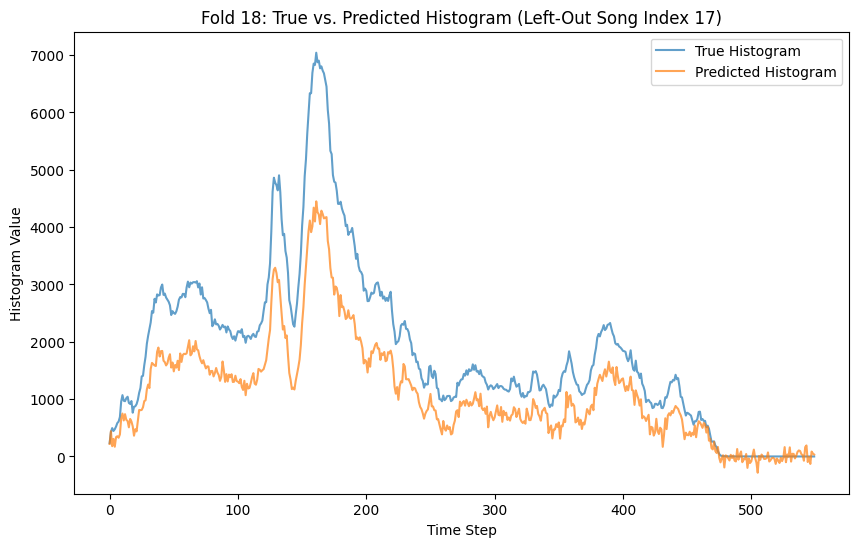

Fold 19: Leaving out song at index 18
Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - loss: 124899.5625
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - loss: 122112.9766
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 119902.0391
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - loss: 118291.3672
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 115969.3516
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 119311.0391
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 120237.8984
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 120028.7891
Test MSE for this fold: 896503.4375
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Test RMSE for this fold: 946.8386840820312


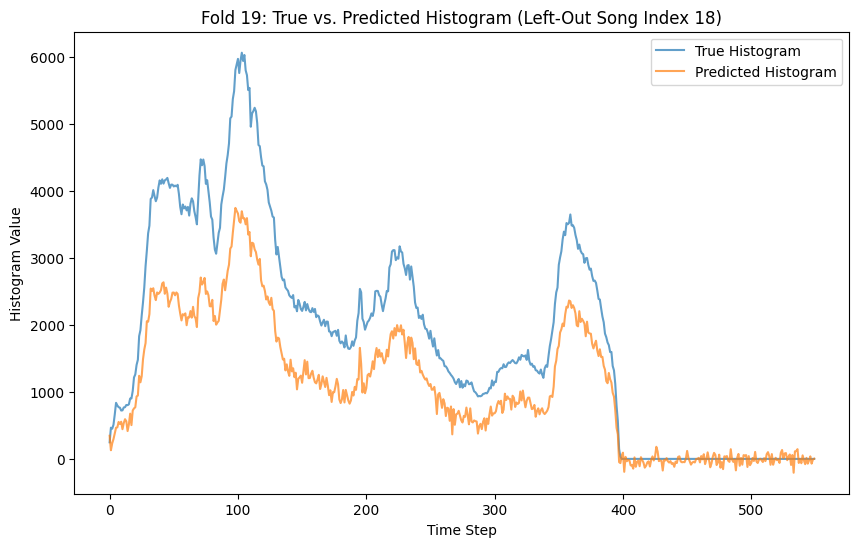

Fold 20: Leaving out song at index 19
Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 112626.3125
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 108466.7266
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 111449.2734
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - loss: 119826.2891
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 113942.0234
Test MSE for this fold: 915694.25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Test RMSE for this fold: 956.9191284179688


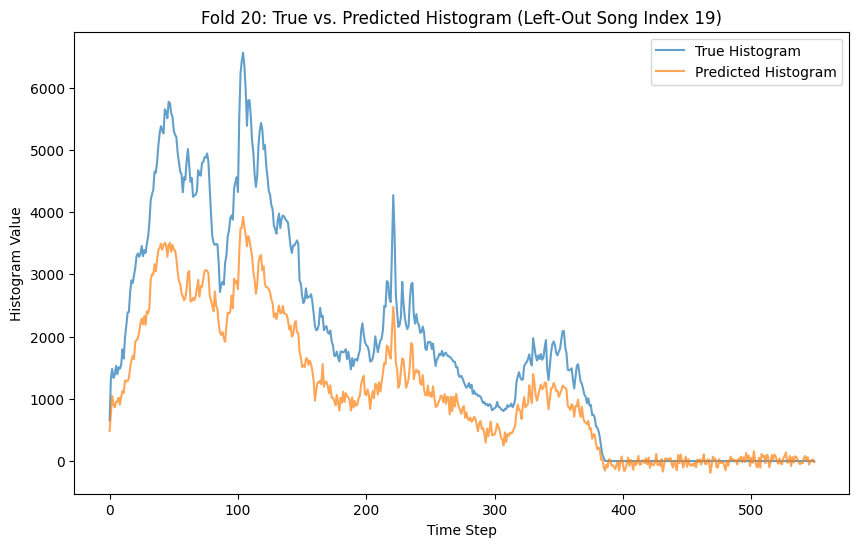

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Initialize Leave-One-Out cross-validator
loo = LeaveOneOut()

model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(550, 70)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(550, activation='linear'))  # 550 max time steps
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Loop through each song for LOO CV and continue training
for fold_number, (train_index, test_index) in enumerate(loo.split(X), start=1):

    print(f"Fold {fold_number}: Leaving out song at index {test_index[0]}")
    # Split the data into training and testing sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    early_stopping = EarlyStopping(monitor='loss', patience=3)
    model.fit(X_train, y_train, epochs=40, batch_size=32, verbose=1, callbacks=[early_stopping])

    # Evaluate the model on the test set
    loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test MSE for this fold: {loss}")

    # Make predictions
    y_pred = model.predict(X_test).flatten()

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test.flatten(), y_pred))
    print(f"Test RMSE for this fold: {rmse}")

    # Plot the true vs. predicted histograms
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.flatten(), label='True Histogram', alpha=0.7)
    plt.plot(y_pred, label='Predicted Histogram', alpha=0.7)
    plt.xlabel('Time Step')
    plt.ylabel('Histogram Value')
    plt.title(f'Fold {fold_number}: True vs. Predicted Histogram (Left-Out Song Index {test_index[0]})')
    plt.legend()
    plt.show()

# Final Validation: Evaluate the model on all songs
#print("\n--- Final Validation ---")
#for i in range(len(X)):
    #y_pred_final = model.predict(np.expand_dims(X[i], axis=0)).flatten() #Need to add 1 to make it 3 parameters  again
    #rmse_final = np.sqrt(mean_squared_error(y[i].flatten(), y_pred_final))

    #print(f"Song {i+1} - Final Validation RMSE: {rmse_final}")

    # Plot the final true vs. predicted histograms
    #plt.figure(figsize=(10, 6))
    #plt.plot(y[i].flatten(), label='True Histogram', alpha=0.7)
    #plt.plot(y_pred_final, label='Predicted Histogram', alpha=0.7)
    #plt.xlabel('Time Step')
    #plt.ylabel('Histogram Value')
    #plt.title(f'Song {i+1} - Final True vs. Predicted Histogram')
    #plt.legend()
    #plt.show()
